### Title: 
# PRE PRODUCTION TEST

### Description:

In this notebook we will perform the process the new data and perform the accuracy and roc curve with all the models.

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
11/12/2020

### Version:
2.0

***

### Libraries

In [1]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Pre-processing
from sklearn import preprocessing,metrics 

    # Visualize DF
from IPython.display import display, HTML

    # Import metrics from sklearn
from sklearn import metrics

    # Load models
import pickle

## Load data

In [2]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'Loan_test_set'

data = pd.read_csv(f'../data/01_raw/{name}.csv', # Path root: here we include an f-string with the variable name to parametrize
                   skiprows=1,                    # We skip the first rows
                   skipfooter=2,                  # We skip the last two rows
                   engine='python')               # To avoid warnings we use the python engine
name = 'X_train'

X_train = pd.read_csv(f'../data/03_processed/{name}.csv',           
                   low_memory = False)

## Data processing

### Select target

In [3]:
    # Merge Default & Charged Off
data['loan_status'] = data['loan_status'].replace({'Default':'Charged Off',
                                                   'Late (31-120 days)':'Charged Off',
                                                   'Late (16-30 days)':'Charged Off',
                                                   'In Grace Period':'Charged Off'})

    # We will only select those observations with "Fully Paid" & "Charged Off"
data_binary = data[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")]

    # Now, we will transform into 0 & 1
dummy_dict = {"Fully Paid":0, "Charged Off":1}

    # Finally, we use the dictiony in the dataset
data = data_binary.replace({"loan_status": dummy_dict})

### Select columns

In [4]:
    # Select the columns of the RFECV
columns = ['loan_status', 'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 
           'verification_status', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 
           'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
           'collections_12_mths_ex_med', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_24m', 
           'open_rv_24m', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
           'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
           'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc_dlq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
           'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 
           'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit']

    # Create a new dataset
data= data[columns]

    # View data
display(HTML(data.head(5).to_html()))

,loan_status,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,open_acc_6m,open_act_il,open_il_24m,open_rv_24m,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc_dlq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit
16,0,3600,36 months,7.49%,A,10+ years,MORTGAGE,120000.0,Not Verified,IN,18.90,0,720,1,NaN,96.0,18,1,5658,14.9%,33,0,0,2,6,6,7,4,13,2147,7980.0,11.3,0,0,166.0,295,3,2,0,NaN,0,1,4,3,17,0,6,100.0,1,0,55699
22,1,4000,36 months,10.49%,B,2 years,RENT,50000.0,Source Verified,TX,33.61,1,670,0,6.0,37.0,10,1,4388,33.2%,33,0,0,0,4,2,4,1,6,13621,39.0,98.4,0,0,148.0,163,15,7,6,NaN,1,1,4,3,15,0,1,87.5,0,0,139652
26,1,8400,36 months,11.39%,B,8 years,MORTGAGE,50000.0,Source Verified,OH,15.63,0,675,0,NaN,NaN,14,0,12831,30.3%,30,0,0,3,2,2,8,7,10,12389,24145.0,33.1,0,0,131.0,143,4,4,4,NaN,0,4,5,11,9,0,5,100.0,0,0,36876
38,0,35000,60 months,25.49%,E,10+ years,MORTGAGE,114000.0,Source Verified,VA,14.04,0,660,1,30.0,NaN,17,0,35694,74.8%,31,0,0,1,2,1,1,4,2,24630,1481.0,95.5,0,0,157.0,220,0,0,4,NaN,4,9,11,11,8,0,1,87.1,0,0,52309
40,0,17000,36 months,7.49%,A,10+ years,MORTGAGE,120000.0,Not Verified,UT,8.41,0,735,0,72.0,89.0,9,1,15406,31.6%,34,0,0,0,2,1,2,1,3,32305,32394.0,32.2,0,0,137.0,119,24,9,2,NaN,0,4,4,6,24,0,1,94.1,1,0,38667


#### Columns transformations

In [5]:
    # With a apply and lamba function we, in the same line, convert the variable into a float and we drop the last 
    # element.
data['int_rate'] = data['int_rate'].apply(lambda x: float(x[:-1]))

    # Now, we convert the revol_util variable into an string object and the apply the same lamba function as above
data['revol_util'] = data['revol_util'].astype('category')
data['revol_util'] = data['revol_util'].apply(lambda x: x[:-1])
data['revol_util'] = data['revol_util'].astype('float64')

    # We create and object we those variable that we want to convert into a categorical named columns_categ
columns_categ = ['grade', 'verification_status', "emp_length", "home_ownership", "loan_status", "addr_state", 
                 "term"]
    
    # Below, we transform the variables into categorical with the astype function.
data[columns_categ] = data[columns_categ].astype('category')
    
    # with a lambda and apply function we convert the different categories into the variable to a number 
data[columns_categ] = data[columns_categ].apply(lambda x: x.cat.codes)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18527 entries, 16 to 96772
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_status                 18527 non-null  int8   
 1   funded_amnt                 18527 non-null  int64  
 2   term                        18527 non-null  int8   
 3   int_rate                    18527 non-null  float64
 4   grade                       18527 non-null  int8   
 5   emp_length                  18527 non-null  int8   
 6   home_ownership              18527 non-null  int8   
 7   annual_inc                  18527 non-null  float64
 8   verification_status         18527 non-null  int8   
 9   addr_state                  18527 non-null  int8   
 10  dti                         18523 non-null  float64
 11  delinq_2yrs                 18527 non-null  int64  
 12  fico_range_low              18527 non-null  int64  
 13  inq_last_6mths              18

### Drop NaN

In [6]:
data = data.dropna()

### Feature Scaling

In [7]:
data.select_dtypes(include = ['float64', 'int64']).columns

Index(['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_24m',
       'open_rv_24m', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc_dlq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens',
       'total_il_high_credit_limit'],
      dtype='object')

In [8]:
     # Instance of preprocessing
scl = preprocessing.StandardScaler()

    # Take numeric columns
columns = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_24m',
       'open_rv_24m', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc_dlq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens',
       'total_il_high_credit_limit']

    # Apply function
data[columns] = scl.fit_transform(data[columns])

    # Chech results
display(HTML(data.head().to_html()))

,loan_status,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,open_acc_6m,open_act_il,open_il_24m,open_rv_24m,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc_dlq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit
168,1,0.723291,1,-0.358954,2,-1,3,-0.084168,2,37,0.343387,-0.532735,0.112187,0.174643,0.449354,-1.351648,0.328362,-0.406967,0.157413,-0.151384,0.029781,-0.148473,-0.077798,-0.990062,0.509896,-0.009866,-0.235329,0.378482,-0.296197,-0.573915,-0.499574,-0.081874,-0.069264,0.0,1.044365,0.468355,-0.173449,0.180607,0.867479,-0.005075,-0.192624,1.110137,0.609338,0.284981,-0.181572,-0.246274,0.544152,-0.104497,-0.960912,0.456376,0.458600
472,1,-0.815615,0,-0.486988,2,-1,4,-1.082262,2,36,0.458780,0.346925,0.635026,0.174643,-1.024842,1.374956,-0.557056,-0.406967,-0.443247,-0.701500,-1.555069,-0.148473,-0.077798,-0.251711,-0.645869,-0.624843,-0.235329,-0.356855,-0.556239,-0.714984,0.225323,-0.829293,-0.069264,0.0,0.433707,-1.839960,0.839485,-0.614062,-0.958621,-1.284714,-0.720400,-0.283122,-0.525160,-0.639817,-0.996465,-0.246274,-0.892409,0.311600,0.730293,-0.497169,-0.608343
573,0,-1.145381,0,-0.700380,1,-1,4,-1.128676,1,22,-0.397927,-0.532735,-0.149233,0.174643,0.080805,-0.237964,-0.202889,0.653700,-0.784810,-1.828351,0.293922,-0.148473,-0.077798,0.486641,-0.260614,-0.009866,0.065570,1.481488,-0.036156,-0.766033,0.700516,-1.811408,-0.069264,0.0,-0.425032,0.040889,-0.848739,-0.931930,-0.349921,-0.261003,-0.192624,-1.211961,-1.376034,-0.177418,0.633322,-0.246274,0.544152,0.998161,2.421497,-0.497169,-0.631448
996,0,1.720832,0,0.579968,3,8,1,-0.155385,1,2,0.143372,0.346925,-0.672072,0.174643,-1.070911,0.146064,1.036696,-0.406967,1.036533,-0.333277,1.614630,-0.148473,-0.077798,0.486641,0.124641,0.605111,1.870969,0.746151,1.784136,-0.227255,1.395297,-0.388785,-0.069264,0.0,-0.100620,-0.717862,-0.679916,-0.614062,0.867479,1.146600,1.390703,-0.283122,0.325713,0.747381,1.176584,-0.246274,-0.413555,0.217978,-0.960912,-0.497169,0.642357
1183,0,0.173682,0,-0.700380,1,1,1,-0.748855,1,4,-0.023074,-0.532735,-0.410652,-0.807560,0.863972,-1.966094,-0.911223,-0.406967,0.093778,0.762519,-0.762644,-0.148473,-0.077798,0.486641,-0.645869,-1.239820,-0.235329,-1.092192,-0.816281,-0.595113,-0.069340,0.264756,-0.069264,0.0,-1.035691,-0.076664,-0.679916,-0.614062,-0.958621,0.464126,0.862927,1.110137,0.042089,0.747381,-0.724834,-0.246274,-0.413555,-0.291741,-0.960912,-0.497169,-0.415421


### Data Y & Data X

In [9]:
    # Set X data
X = data.drop("loan_status", axis = 1)

    # Set y data
y = data["loan_status"]

    # Check dimensions
X.shape, y.shape

((748, 50), (748,))

### One Hot Encoding

In [10]:
    # Select the columns without ordinal relationship
cat_columns = ['home_ownership', 'addr_state', 'verification_status']
    # One Hot Enconding, droping the first column in order to save K-1 
X = pd.get_dummies(X, columns=cat_columns, drop_first=True)

    # Check results
display(HTML(X.head().to_html()))

,funded_amnt,term,int_rate,grade,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,open_acc_6m,open_act_il,open_il_24m,open_rv_24m,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc_dlq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,home_ownership_1,home_ownership_3,home_ownership_4,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,addr_state_6,addr_state_7,addr_state_8,addr_state_9,addr_state_10,addr_state_11,addr_state_12,addr_state_13,addr_state_14,addr_state_15,addr_state_16,addr_state_17,addr_state_18,addr_state_19,addr_state_20,addr_state_21,addr_state_22,addr_state_23,addr_state_24,addr_state_25,addr_state_26,addr_state_27,addr_state_28,addr_state_29,addr_state_30,addr_state_31,addr_state_32,addr_state_33,addr_state_34,addr_state_35,addr_state_36,addr_state_37,addr_state_38,addr_state_39,addr_state_40,addr_state_41,addr_state_42,addr_state_43,addr_state_44,addr_state_46,addr_state_47,addr_state_48,verification_status_1,verification_status_2
168,0.723291,1,-0.358954,2,-1,-0.084168,0.343387,-0.532735,0.112187,0.174643,0.449354,-1.351648,0.328362,-0.406967,0.157413,-0.151384,0.029781,-0.148473,-0.077798,-0.990062,0.509896,-0.009866,-0.235329,0.378482,-0.296197,-0.573915,-0.499574,-0.081874,-0.069264,0.0,1.044365,0.468355,-0.173449,0.180607,0.867479,-0.005075,-0.192624,1.110137,0.609338,0.284981,-0.181572,-0.246274,0.544152,-0.104497,-0.960912,0.456376,0.458600,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
472,-0.815615,0,-0.486988,2,-1,-1.082262,0.458780,0.346925,0.635026,0.174643,-1.024842,1.374956,-0.557056,-0.406967,-0.443247,-0.701500,-1.555069,-0.148473,-0.077798,-0.251711,-0.645869,-0.624843,-0.235329,-0.356855,-0.556239,-0.714984,0.225323,-0.829293,-0.069264,0.0,0.433707,-1.839960,0.839485,-0.614062,-0.958621,-1.284714,-0.720400,-0.283122,-0.525160,-0.639817,-0.996465,-0.246274,-0.892409,0.311600,0.730293,-0.497169,-0.608343,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
573,-1.145381,0,-0.700380,1,-1,-1.128676,-0.397927,-0.532735,-0.149233,0.174643,0.080805,-0.237964,-0.202889,0.653700,-0.784810,-1.828351,0.293922,-0.148473,-0.077798,0.486641,-0.260614,-0.009866,0.065570,1.481488,-0.036156,-0.766033,0.700516,-1.811408,-0.069264,0.0,-0.425032,0.040889,-0.848739,-0.931930,-0.349921,-0.261003,-0.192624,-1.211961,-1.376034,-0.177418,0.633322,-0.246274,0.544152,0.998161,2.421497,-0.497169,-0.631448,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
996,1.720832,0,0.579968,3,8,-0.155385,0.143372,0.346925,-0.672072,0.174643,-1.070911,0.146064,1.036696,-0.406967,1.036533,-0.333277,1.614630,-0.148473,-0.077798,0.486641,0.124641,0.605111,1.870969,0.746151,1.784136,-0.227255,1.395297,-0.388785,-0.069264,0.0,-0.100620,-0.717862,-0.679916,-0.614062,0.867479,1.146600,1.390703,-0.283122,0.325713,0.747381,1.176584,-0.246274,-0.413555,0.217978,-0.960912,-0.497169,0.642357,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1183,0.173682,0,-0.700380,1,1,-0.748855,-0.023074,-0.532735,-0.410652,-0.807560,0.863972,-1.966094,-0.911223,-0.406967,0.093778,0.762519,-0.762644,-0.148473,-0.077798,0.486641,-0.645869,-1.239820,-0.235329,-1.092192,-0.816281,-0.595113,-0.069340,0.264756,-0.069264,0.0,-1.035691,-0.076664,-0.679916,-0.614062,-0.958621,0.464126,0.862927,1.110137,0.042089,0.747381,-0.724834,-0.246274,-0.413555,-0.291741,-0.960912,-0.497169,-0.415421,1,0,0,0,

In [11]:
X.shape

(748, 99)

#### Missing columns

In [12]:
    # Select the columns of the training dataset
X_train_columns = X_train[X_train.columns]
list(X_train_columns.columns)

['funded_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'open_acc_6m',
 'open_act_il',
 'open_il_24m',
 'open_rv_24m',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc_dlq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_tl',
 'num_il_tl',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_il_high_credit_limit',
 'home_ownership_1',
 'home_ownership_2',
 'home_ownership_3',
 'addr_state_1',
 'addr_state_2',
 'addr_state_3',
 'addr_state_

In [13]:
    # We create an object with all the columns
col_training = ['funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
               'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 
               'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 
               'open_il_24m', 'open_rv_24m', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
               'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
               'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc_dlq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
               'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 
               'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit', 'home_ownership_1', 'home_ownership_2', 
               'home_ownership_3', 'addr_state_1', 'addr_state_2', 'addr_state_3', 'addr_state_4', 'addr_state_5', 
               'addr_state_6', 'addr_state_7', 'addr_state_8', 'addr_state_9', 'addr_state_10', 'addr_state_11', 
               'addr_state_12', 'addr_state_13', 'addr_state_14', 'addr_state_15', 'addr_state_16', 'addr_state_17', 
               'addr_state_18',  'addr_state_19', 'addr_state_20', 'addr_state_21', 'addr_state_22', 'addr_state_23',
               'addr_state_24', 'addr_state_25', 'addr_state_26', 'addr_state_27', 'addr_state_28', 'addr_state_29',
               'addr_state_30', 'addr_state_31', 'addr_state_32', 'addr_state_33', 'addr_state_34', 'addr_state_35', 
               'addr_state_36', 'addr_state_37', 'addr_state_38', 'addr_state_39', 'addr_state_40', 'addr_state_41',
               'addr_state_42', 'addr_state_43', 'addr_state_44', 'addr_state_45', 'addr_state_46', 'addr_state_47', 
               'addr_state_48', 'addr_state_49', 'addr_state_50', 'verification_status_1', 'verification_status_2']

In [14]:
    # Create a list of columns so we can enforce the order of columns later on
processed_columns = list(X_train.columns[:])

In [15]:
    # Remove additional columns not presented in the data test
for col in X.columns:
        if col not in col_training:
            print("Removing additional features {}".format(col))
            X.drop(col, axis=1, inplace=True)

Removing additional features home_ownership_4


In [16]:
    # Add the missing columns. We can set all missing columns to the vector of ceros since does values did not appear in test
for col in col_training:
        if col not in X.columns:
            print("Adding missing feature {}".format(col))
            X[col] = 0

Adding missing feature home_ownership_2
Adding missing feature addr_state_45
Adding missing feature addr_state_49
Adding missing feature addr_state_50


In [17]:
    # Order columns
X = X[processed_columns]

    # Check results
display(HTML(X.head().to_html()))

,funded_amnt,term,int_rate,grade,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,open_acc_6m,open_act_il,open_il_24m,open_rv_24m,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc_dlq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,home_ownership_1,home_ownership_2,home_ownership_3,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,addr_state_6,addr_state_7,addr_state_8,addr_state_9,addr_state_10,addr_state_11,addr_state_12,addr_state_13,addr_state_14,addr_state_15,addr_state_16,addr_state_17,addr_state_18,addr_state_19,addr_state_20,addr_state_21,addr_state_22,addr_state_23,addr_state_24,addr_state_25,addr_state_26,addr_state_27,addr_state_28,addr_state_29,addr_state_30,addr_state_31,addr_state_32,addr_state_33,addr_state_34,addr_state_35,addr_state_36,addr_state_37,addr_state_38,addr_state_39,addr_state_40,addr_state_41,addr_state_42,addr_state_43,addr_state_44,addr_state_45,addr_state_46,addr_state_47,addr_state_48,addr_state_49,addr_state_50,verification_status_1,verification_status_2
168,0.723291,1,-0.358954,2,-1,-0.084168,0.343387,-0.532735,0.112187,0.174643,0.449354,-1.351648,0.328362,-0.406967,0.157413,-0.151384,0.029781,-0.148473,-0.077798,-0.990062,0.509896,-0.009866,-0.235329,0.378482,-0.296197,-0.573915,-0.499574,-0.081874,-0.069264,0.0,1.044365,0.468355,-0.173449,0.180607,0.867479,-0.005075,-0.192624,1.110137,0.609338,0.284981,-0.181572,-0.246274,0.544152,-0.104497,-0.960912,0.456376,0.458600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
472,-0.815615,0,-0.486988,2,-1,-1.082262,0.458780,0.346925,0.635026,0.174643,-1.024842,1.374956,-0.557056,-0.406967,-0.443247,-0.701500,-1.555069,-0.148473,-0.077798,-0.251711,-0.645869,-0.624843,-0.235329,-0.356855,-0.556239,-0.714984,0.225323,-0.829293,-0.069264,0.0,0.433707,-1.839960,0.839485,-0.614062,-0.958621,-1.284714,-0.720400,-0.283122,-0.525160,-0.639817,-0.996465,-0.246274,-0.892409,0.311600,0.730293,-0.497169,-0.608343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
573,-1.145381,0,-0.700380,1,-1,-1.128676,-0.397927,-0.532735,-0.149233,0.174643,0.080805,-0.237964,-0.202889,0.653700,-0.784810,-1.828351,0.293922,-0.148473,-0.077798,0.486641,-0.260614,-0.009866,0.065570,1.481488,-0.036156,-0.766033,0.700516,-1.811408,-0.069264,0.0,-0.425032,0.040889,-0.848739,-0.931930,-0.349921,-0.261003,-0.192624,-1.211961,-1.376034,-0.177418,0.633322,-0.246274,0.544152,0.998161,2.421497,-0.497169,-0.631448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
996,1.720832,0,0.579968,3,8,-0.155385,0.143372,0.346925,-0.672072,0.174643,-1.070911,0.146064,1.036696,-0.406967,1.036533,-0.333277,1.614630,-0.148473,-0.077798,0.486641,0.124641,0.605111,1.870969,0.746151,1.784136,-0.227255,1.395297,-0.388785,-0.069264,0.0,-0.100620,-0.717862,-0.679916,-0.614062,0.867479,1.146600,1.390703,-0.283122,0.325713,0.747381,1.176584,-0.246274,-0.413555,0.217978,-0.960912,-0.497169,0.642357,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1183,0.173682,0,-0.700380,1,1,-0.748855,-0.023074,-0.532735,-0.410652,-0.807560,0.863972,-1.966094,-0.911223,-0.406967,0.093778,0.762519,-0.762644,-0.148473,-0.077798,0.486641,-0.645869,-1.239820,-0.235329,-1.092192,-0.816281,-0.595113,-0.069340,0.264756,-0.069264,0.0,-1.035691,-0.076664,-0.679916,-0.614062,-0.958621,0.464126,0.862927,1.110137,0.042089,0.747381,-0.724834,-0

***

## Testing

### Logistic Regression

In [18]:
    # Parametrize
filename = 'logistic_regression'

    # Load model
model = pickle.load(open(f'../data/04_models/{filename}.sav', 'rb'))

    # Print accuracy
result = model.score(X, y)
print(result)

0.6778074866310161


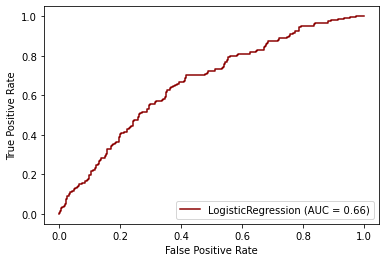

In [19]:
metrics.plot_roc_curve(model, X, y, color='#8B0000');

### Random Forest

In [20]:
    # Parametrize
filename = 'random_forest'

    # Load model
model = pickle.load(open(f'../data/04_models/{filename}.sav', 'rb'))

    # Print accuracy
result = model.score(X, y)
print(result)

0.6991978609625669


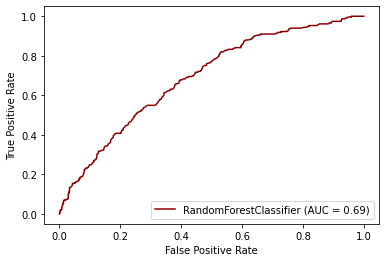

In [21]:
metrics.plot_roc_curve(model, X, y, color='#8B0000');

### XGBoost

In [22]:
    # Parametrize
filename = 'xgboost_tuned'

    # Load model
model = pickle.load(open(f'../data/04_models/{filename}.sav', 'rb'))

    # Print accuracy
result = model.score(X, y)
print(result)

0.6644276844868537


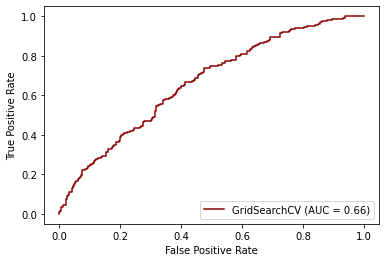

In [23]:
metrics.plot_roc_curve(model, X, y, color='#8B0000');

### Support Vector Machine

In [24]:
    # Parametrize
filename = 'svm'

    # Load model
model = pickle.load(open(f'../data/04_models/{filename}.sav', 'rb'))

    # Print accuracy
result = model.score(X, y)
print(result)

0.5828877005347594


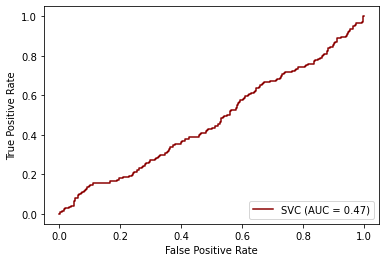

In [25]:
metrics.plot_roc_curve(model, X, y, color='#8B0000');